<a href="https://colab.research.google.com/github/hananbahtiti/Hybrid-Intrusion-detection-Systems/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [1]:
!wget -O NGIDS-DS.rar https://unsworks.unsw.edu.au/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/download

--2025-04-24 21:24:22--  https://unsworks.unsw.edu.au/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/download
Resolving unsworks.unsw.edu.au (unsworks.unsw.edu.au)... 54.253.215.118
Connecting to unsworks.unsw.edu.au (unsworks.unsw.edu.au)|54.253.215.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://unsworks.unsw.edu.au/server/api/core/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/content [following]
--2025-04-24 21:24:23--  https://unsworks.unsw.edu.au/server/api/core/bitstreams/0ac2820a-5131-43ab-90b2-c624c8d73649/content
Reusing existing connection to unsworks.unsw.edu.au:443.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/x-rar-compressed]
Saving to: ‘NGIDS-DS.rar’

NGIDS-DS.rar            [        <=>         ] 941.51M  13.5MB/s    in 65s     

2025-04-24 21:25:29 (14.4 MB/s) - ‘NGIDS-DS.rar’ saved [987249484]



In [2]:
!unrar x /content/NGIDS-DS.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/NGIDS-DS.rar

Creating    NGIDS                                                     OK
Creating    NGIDS/NGIDS-DS-v1                                         OK
Extracting  NGIDS/NGIDS-DS-v1/feature_descr.csv                            0%  OK 
Extracting  NGIDS/NGIDS-DS-v1/ground_truth.csv                             0%  OK 
Creating    NGIDS/NGIDS-DS-v1/host logs                               OK
Extracting  NGIDS/NGIDS-DS-v1/host logs/1.csv                              0%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/10.csv                             0%  1%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/11.csv                             1%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/12.csv                             1%  2%  OK 
Extracting  NGIDS/NGIDS-DS-v1/host logs/13.csv                             2%  OK 
Extrac

#Host data processing

In [ ]:
!pip install tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import os
import glob
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [ ]:
class HostPreprocessing():
  def __init__(self):
    pass

  def __file_path_collection(self, folder_path, ends='.csv'):
    try:
      joined_list = []
      for file_name in os.listdir(folder_path):
        file_name = os.path.join(folder_path, file_name)
        if os.path.isfile(file_name) and file_name.endswith(ends):
          joined_list.append(file_name)
      return joined_list

    except Exception as e:
      return f"An error occurred: {e}"


  def rename_columns(self, folder_path):
    files = self.__file_path_collection(folder_path)
    try:
      for file in tqdm(files, desc="Renaming columns") :
        df = pd.read_csv(file)
        column_name = df.columns.tolist()
        df.rename(columns={
            column_name[0]:'Date',
            column_name[1]:'Time',
            column_name[2]:'Unique_Identification',
            column_name[3]:'Execution_Path',
            column_name[4]:'System_Calls_Identifiers',
            column_name[5]:"Event's_Unique_Identification",
            column_name[6]:'attacks',
            column_name[7]:"Sub_Type_Attack",
            column_name[8]:"Label"
            }, inplace=True)
        df.to_csv(file, index=False)
      return f"done files..."

    except Exception as e:
      return f"An error occurred: {e}"


  def data_encoding(self, folder_path, column_number : int):
    files = self.__file_path_collection(folder_path)
    encoder = LabelEncoder()
    all_value = []
    try:
      for file in tqdm(files, desc="Extract all values from files"):
        df = pd.read_csv(file)
        all_value.extend(df.iloc[:, column_number].dropna().unique())
        #print( len(df.iloc[:, column_number].dropna().unique()) , file )
      encoder.fit(all_value)

      for file in tqdm(files, desc="encoder data"):
        df = pd.read_csv(file)
        df.iloc[:, column_number] = encoder.transform(df.iloc[:, column_number])
        #print(len(df.iloc[:, column_number].dropna().unique()), df.iloc[:, column_number].dropna().unique(), file )
        df.to_csv(file, index=False)
      return f"done file..."

    except Exception as e:
      return f"An error occurred: {e}"


  def paths_encoding(self, folder_path, column_number: int):
    files = self.__file_path_collection(folder_path)
    unique_parts_set = set()
    max_parts_len = 0

    try:
        # Step 1: Collect unique path parts and max length
        for file in tqdm(files, desc="Collecting unique path parts"):
            for chunk in pd.read_csv(file, chunksize=10000):
                paths = chunk.iloc[:, column_number].dropna().astype(str)
                for path in paths:
                    parts = path.strip("/").split("/")
                    unique_parts_set.update(parts)
                    if len(parts) > max_parts_len:
                        max_parts_len = len(parts)

        # Step 2: Create a dictionary to map parts to indices
        part_to_index = {part: idx for idx, part in enumerate(unique_parts_set)}

        # Step 3: Encode paths and write to new files
        for file in tqdm(files, desc="Encoding and saving data"):
            output_file = file.replace(".csv", "_encoded.csv")
            first = True

            for chunk in pd.read_csv(file, chunksize=10000):
                paths = chunk.iloc[:, column_number].fillna("").astype(str)

                # Encode paths and pad
                encoded_matrix = np.full((len(paths), max_parts_len), -1, dtype=int)
                for i, path in enumerate(paths):
                    parts = path.strip("/").split("/")
                    encoded = [part_to_index.get(part, -1) for part in parts]
                    encoded_matrix[i, :len(encoded)] = encoded

                encoded_df = pd.DataFrame(encoded_matrix, index=chunk.index,
                                          columns=[f"path_part_{i+1}" for i in range(max_parts_len)])
                final_df = pd.concat([chunk.reset_index(drop=True), encoded_df], axis=1)
                final_df.to_csv(output_file, mode='a', header=first, index=False)
                first = False

        return "✅ Path encoding and file saving completed successfully."

    except Exception as e:
        return f"❌ An error occurred: {e}"



  def remove_column_from_encoded_files(self, folder_path, column_to_remove):
    files = self.__file_path_collection(folder_path, ends='_encoded.csv')
    try:
      for file in tqdm(files, desc="read all files"):
        df = pd.read_csv(file, low_memory=False)
        if column_to_remove in df.columns:
          df = df.drop(columns=[column_to_remove])
          df.to_csv(file, index=False)
      return  f"done file..."

    except Exception as e:
      return f"An error occurred: {e}"


  def extract_datetime_features(self, folder_path, date_col, time_col ):
    files = self.__file_path_collection(folder_path, ends='_encoded.csv') # Assign the output of __file_path_collection to files
    try:
      for file in tqdm(files, desc="read all files"): # Iterate through the 'files' list, not 'file_paths'
        df = pd.read_csv(file) # Read each file into a DataFrame
        if date_col in df.columns and time_col in df.columns :
          df[date_col] = pd.to_datetime(df[date_col], format='%d/%m/%Y', errors='coerce', dayfirst=True)

          df['year'] = df[date_col].dt.year
          df['month'] = df[date_col].dt.month
          df['day'] = df[date_col].dt.day

          # Assuming 'Time' column is string and needs to be converted to datetime
          df[time_col] = pd.to_datetime(df[time_col], format='%H:%M:%S', errors='coerce', dayfirst=True)

          df['hour'] = df[time_col].dt.hour
          df['minute'] = df[time_col].dt.minute
          df['second'] = df[time_col].dt.second

          df.drop(columns=[date_col, time_col], inplace=True)

          df.to_csv(file, index=False) # Save changes back to the original file
          print(f"✅ Processed: {df.head(3)}")

    except Exception as e:
        print(f"❌ Error in {file}: {e}") # Print the error and the file name



  def delete_data(self, folder_path):
    file_paths = self.__file_path_collection(folder_path, ends='_encoded.csv')
    try:
       for file in tqdm(file_paths, desc="read all files"):
          df = pd.read_csv(file)
          df = df.loc[:, df.nunique() > 1]
          df.to_csv(file, index=False)
          return f"Columns containing only one value are deleted..."
    except Exception as e:
      return f"An error occurred: {e}"



  def file_collection(self, folder_path):
    try:
      file_paths = self.__file_path_collection(folder_path)
      if file_paths:
        output_folder = os.path.join(os.getcwd(),'files')
        os.makedirs(output_folder ,exist_ok=True)
        output_file = os.path.join(output_folder,"final.csv")

        for file in tqdm(file_paths, desc="read all files"):

          first = True
          chunk = pd.read_csv(file, chunksize=10000)
          for part in chunk:
            part.to_csv(output_file, mode='a', header=first, index=False)
            first = False

      return  f"done file..."

    except Exception as e:
      return f"An error occurred: {e}"


a = HostPreprocessing()
#a.file_path_collection("/content/NGIDS/NGIDS-DS-v1/host logs")
#a.file_collection("/content/NGIDS/NGIDS-DS-v1/host logs")
#a.rename_columns( '/content/NGIDS/NGIDS-DS-v1/host logs')
#a.data_encoding('/content/NGIDS/NGIDS-DS-v1/host logs', column_number=6)
#a.data_encoding('/content/NGIDS/NGIDS-DS-v1/host logs', column_number=7)

#c=a.paths_encoding('/content/NGIDS/NGIDS-DS-v1/host logs', column_number=3)
#a.remove_column_from_encoded_files(folder_path='/content/NGIDS/NGIDS-DS-v1/host logs',
#                                  column_to_remove='Execution_Path')
#a.extract_datetime_features(  folder_path='/content/NGIDS/NGIDS-DS-v1/host logs'
#                            ,date_col='Date',
#                            time_col='Time' )
a.delete_data( folder_path='/content/NGIDS/NGIDS-DS-v1/host logs')

read all files:   0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


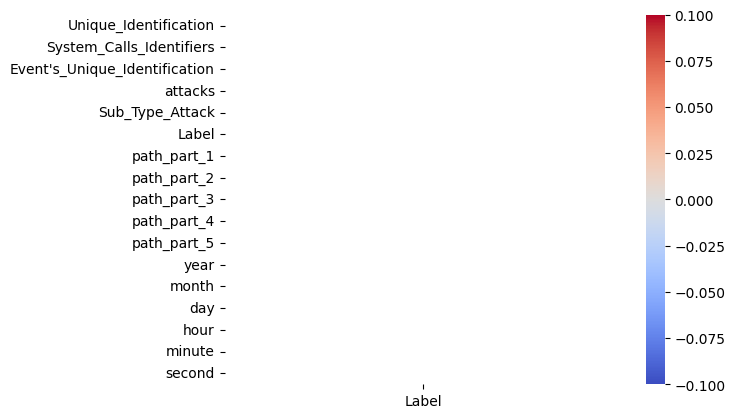

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt

# فقط الأعمدة الرقمية
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# رسم heatmap للعلاقة مع التصنيف
correlation = df[numeric_cols].corr()
sns.heatmap(correlation[['Label']], annot=True, cmap='coolwarm')
plt.show()

In [12]:
import pandas as pd


file = '/content/NGIDS/NGIDS-DS-v1/host logs/10_encoded.csv'
# Load the data
data = pd.read_csv(file)

# Calculate the Pearson correlation coefficient
corr = data['Unique_Identification'].corr(data['Label'], method='pearson')

print('Pearson correlation coefficient:', corr)

Pearson correlation coefficient: nan


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
file = '/content/NGIDS/NGIDS-DS-v1/host logs/10_encoded.csv'
df = pd.read_csv(file)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990000 entries, 0 to 1989999
Data columns (total 17 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unique_Identification          float64
 1   System_Calls_Identifiers       float64
 2   Event's_Unique_Identification  float64
 3   attacks                        float64
 4   Sub_Type_Attack                float64
 5   Label                          float64
 6   path_part_1                    float64
 7   path_part_2                    float64
 8   path_part_3                    float64
 9   path_part_4                    float64
 10  path_part_5                    float64
 11  year                           float64
 12  month                          float64
 13  day                            float64
 14  hour                           float64
 15  minute                         float64
 16  second                         float64
dtypes: float64(17)
memory usage: 258.1 MB


,Unique_Identification,System_Calls_Identifiers,Event's_Unique_Identification,attacks,Sub_Type_Attack,Label,path_part_1,path_part_2,path_part_3,path_part_4,path_part_5,year,month,day,hour,minute,second
0,2111.0,168.0,8441500.0,7.0,52.0,0.0,102.0,87.0,76.0,-1.0,-1.0,2016.0,3.0,11.0,16.0,25.0,47.0
1,2318.0,168.0,8441325.0,7.0,52.0,0.0,102.0,87.0,49.0,-1.0,-1.0,2016.0,3.0,11.0,16.0,25.0,47.0
2,4493.0,78.0,8440867.0,7.0,52.0,0.0,102.0,104.0,60.0,-1.0,-1.0,2016.0,3.0,11.0,16.0,25.0,49.0
3,4493.0,78.0,8440875.0,7.0,52.0,0.0,102.0,104.0,60.0,-1.0,-1.0,2016.0,3.0,11.0,16.0,25.0,49.0
4,4519.0,78.0,8440865.0,7.0,52.0,0.0,102.0,104.0,60.0,-1.0,-1.0,2016.0,3.0,11.0,16.0,25.0,49.0


In [ ]:
df = pd.read_csv('/content/NGIDS/NGIDS-DS-v1/host logs/21_encoded.csv')
df['Time'].value_counts() # Changed 'vaule_counts()' to 'value_counts()'

,count
Time,
6:00:00,748
5:46:00,622
5:57:00,585
5:48:00,551
5:52:00,541
...,...
4:42:00,1
4:24:15,1
4:24:00,1


#network




In [ ]:
pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.3 MB/s eta 0:00:00


In [ ]:
import csv
import json
import os
import re
from tqdm import tqdm
from scapy.all import PcapReader

In [ ]:
class NetworkPreprocessing:
  def __init__(self):
    pass


  def extract_tcp_option(self, option, key):
    for opt in option:
      if opt[0] == key:
        return opt[1]
    return None


  def delete_data(self, file_path):
    df = pd.read_csv(file_path)
    df = df.loc[:, df.nunique() > 1]
    df.to_csv(file_path, index=False)
    return f"Columns containing only one value are deleted..."

  def convert_pcap_csv(self, pcap_file, csv_file):
    try:
      print("Countig packages...")
      with PcapReader(pcap_file) as count_reader:
        total_packets = sum(1 for _ in count_reader)
        print(f"Total number of packages: {total_packets}")

      print("Start converting to csv file...")
      with PcapReader(pcap_file) as packets:
        with open(csv_file, mode='w', newline="") as file:
          writer = csv.writer(file)
          writer.writerow([
              "Packet Number", "Ethernet DST", "Ethernet SRC", "Ethernet Type",
              "IP Version", "IP IHL", "IP TOS", "IP Length", "IP ID", "IP Flags",
              "IP Fragmentation", "IP TTL", "IP Proto", "IP Checksum",
              "IP Src", "IP Dst", "TCP Src Port", "TCP Dst Port", "TCP Seq",
              "TCP Ack", "TCP Data Offset", "TCP Reserved", "TCP Flags",
              "TCP Window", "TCP Checksum", "TCP Urgent Pointer", "TCP Options MSS",
              "TCP Options WScale", "TCP Options NOP","Hexdump"
          ])

          for i, packet in enumerate(tqdm(packets,total=total_packets, desc="Packet processing")):
            if packet.haslayer('Ethernet'):
              eth_dst = packet['Ethernet'].dst
              eth_src = packet['Ethernet'].src
              eth_type = packet['Ethernet'].type
            else:
              eth_dst = eth_src = eth_type = None

            if packet.haslayer('IP'):
              ip_version = packet['IP'].version
              ip_ihl = packet['IP'].ihl
              ip_tos = packet['IP'].tos
              ip_len = packet['IP'].len
              ip_id = packet['IP'].id
              ip_flags = packet['IP'].flags
              ip_frag = packet['IP'].frag
              ip_ttl = packet['IP'].ttl
              ip_proto = packet['IP'].proto
              ip_chksum = packet['IP'].chksum
              ip_src = packet['IP'].src
              ip_dst = packet['IP'].dst
            else:
              ip_version = ip_ihl = ip_tos = ip_len = ip_id = ip_flags = ip_frag = ip_ttl = ip_proto = ip_chksum = ip_src = ip_dst = None

            if packet.haslayer('TCP'):
              tcp_sport = packet['TCP'].sport
              tcp_dport = packet['TCP'].dport
              tcp_seq = packet['TCP'].seq
              tcp_ack = packet['TCP'].ack
              tcp_dataofs = packet['TCP'].dataofs
              tcp_reserved = packet['TCP'].reserved
              tcp_flags = packet['TCP'].flags
              tcp_window = packet['TCP'].window
              tcp_chksum = packet['TCP'].chksum
              tcp_urgptr = packet['TCP'].urgptr
              tcp_options = packet['TCP'].options

              tcp_mss = self.extract_tcp_option(tcp_options, 'MSS')
              tcp_wscale = self.extract_tcp_option(tcp_options, 'WScale')
              tcp_nop_count = self.extract_tcp_option(tcp_options, 'NOP')

            else:
              tcp_sport = tcp_dport = tcp_seq = tcp_ack = tcp_dataofs = tcp_reserved = tcp_flags = tcp_window = tcp_chksum = tcp_urgptr = tcp_mss = tcp_wscale = tcp_nop_count = None

            raw_data = packet.original.hex()
            writer.writerow([
                i + 1, eth_dst, eth_src, eth_type,
                  ip_version, ip_ihl, ip_tos, ip_len, ip_id, ip_flags,
                  ip_frag, ip_ttl, ip_proto, ip_chksum,
                  ip_src, ip_dst, tcp_sport, tcp_dport, tcp_seq,
                  tcp_ack, tcp_dataofs, tcp_reserved, tcp_flags,
                  tcp_window, tcp_chksum, tcp_urgptr, tcp_mss, tcp_wscale, tcp_nop_count,
                  raw_data
            ])

      return f"The file has been converted to csv successfully."
    except Exception as e:
      return f"An error occurred: {e}"

a = NetworkPreprocessing()
#a.convert_pcap_csv(pcap_file='/content/NGIDS/NGIDS-DS-v1/NGIDS.pcap',
#                   csv_file='/content/drive/MyDrive/hybrid_IDS/network.csv')
#a.delete_data(file_path='/content/drive/MyDrive/hybrid_IDS/network.csv')

'Columns containing only one value are deleted...'

In [ ]:
class PcapFileProcessing:
  def __init__(self) -> None:
    pass



  def delete_data(self, file_path):
    df = pd.read_csv(file_path)
    df = df.loc[:, df.nunique() > 1]
    df.to_csv(file_path, index=False)
    return f"Columns containing only one value are deleted..."


  def date_time_columns(self, file_path, csv_file):
    try:
        df = pd.read_csv(file_path, dtype=str)
        df.columns = df.columns.str.strip()
        if 'timestamp' not in df.columns:
            return "Error: The 'timestamp' column is missing from the file."

        df['timestamp'] = df['timestamp'].astype(str).str.strip()

        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', dayfirst=True)

        if df['timestamp'].isnull().all():
            return "All values in 'timestamp' are invalid and could not be converted."

        # Extract date and time
        df['date'] = df['timestamp'].dt.strftime('%d/%m/%Y')
        df['time'] = df['timestamp'].dt.strftime('%H:%M:%S')

        # Save the result
        df.to_csv(csv_file, index=False)

        return "Successfully converted 'timestamp' to 'date' and 'time'."

    except Exception as e:
        return f"An error occurred during conversion: {e}"





  def convert_log_csv(self, log_file, csv_file):
    try:
      print("Start converting to csv file...")
      with open(log_file, "r") as logfile:
        log_data = logfile.read()
      pattern = re.compile(
          r'(?P<timestamp>\d{2}/\d{2}/\d{4}-\d{2}:\d{2}:\d{2}\.\d+)\s+\[\*\*\]\s+\[(?P<sid>[^]]+)\]\s+(?P<signature>.*?)\s+\[\*\*\]\s+\[Classification:\s+(?P<classification>.*?)\]\s+\[Priority:\s+(?P<priority>\d+)\]\s+\{(?P<protocol>\w+)\}\s+(?P<src_ip>\d+\.\d+\.\d+\.\d+):(?P<src_port>\d+)\s+->\s+(?P<dst_ip>\d+\.\d+\.\d+\.\d+):(?P<dst_port>\d+)'
          )
      with open(csv_file, "w", newline="") as csvfile:
        fieldnames = ['timestamp', 'sid', 'signature', 'classification',
                      'priority', 'protocol','src_ip', 'src_port', 'dst_ip', 'dst_port']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for match in pattern.finditer(log_data):
          writer.writerow(match.groupdict())

      return f"The file has been converted to csv successfully."

    except Exception as e:
      return f"An error occurred: {e}"


  def convert_json_csv(self, json_file, csv_file):
    try:
      print("Start converting JSON to CSV...")
      with open(json_file, 'r') as f:
        data = [json.loads(line) for line in f if line.strip()]

      fieldnames = set()
      for row in data:
          fieldnames.update(row.keys())

      fieldnames = list(fieldnames)

      with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)

        for row in data:
          writer.writerow(row.get(field, '') for field in fieldnames)

      return f"The file has been converted to csv successfully."

    except Exception as e:
      return f"An error occurred: {e}"



a = PcapFileProcessing()
#a.convert_log_csv( log_file="/content/drive/MyDrive/hybrid_IDS/fast.log",
#                  csv_file="/content/drive/MyDrive/hybrid_IDS/alerts.csv")

#a.convert_json_csv(json_file='/content/drive/MyDrive/hybrid_IDS/eve.json',
#                   csv_file='/content/drive/MyDrive/hybrid_IDS/eve.csv')

#a.delete_data( file_path='/content/drive/MyDrive/hybrid_IDS/eve.csv')
a.date_time_columns(file_path='/content/drive/MyDrive/hybrid_IDS/eve.csv',
                    csv_file='/content/drive/MyDrive/hybrid_IDS/dataset/eve.csv')

'تم تحويل timestamp بنجاح إلى date و time.'